In [84]:
!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 27.1 MB/s eta 0:00:000:00:01m eta 0:00:01


In [57]:
from math import radians, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

In [2]:
# 1. Cargar dataset
df_trips = pd.read_csv("../data/train.csv")

In [3]:
# Generar listado auxiliar de taxistas
unique_taxis = df_trips["TAXI_ID"].unique()

In [4]:
# 2. Convertir TIMESTAMP (unix seconds) a datetime
df_trips["datetime"] = pd.to_datetime(df_trips["TIMESTAMP"], unit="s")

In [5]:
# 3. Crear franja de 2 horas (floor a bloques de 2h)
df_trips["time_2h"] = df_trips["datetime"].dt.floor("2H")

In [6]:
# 4. Contar viajes por franja (cada TRIP_ID es un viaje)
trips_2h = (
    df_trips.groupby("time_2h")["TRIP_ID"]
    .nunique()
    .sort_values(ascending=False)
)

In [7]:
# 5. Mostrar las 10 franjas con más viajes
print(trips_2h.head(10))

time_2h
2013-11-26 08:00:00    1217
2014-01-01 02:00:00    1149
2014-06-24 02:00:00    1120
2014-06-24 04:00:00    1118
2014-01-01 04:00:00    1097
2014-05-11 04:00:00     997
2013-11-26 10:00:00     972
2013-11-26 16:00:00     968
2014-06-08 02:00:00     965
2014-05-04 00:00:00     963
Name: TRIP_ID, dtype: int64


In [8]:
best_slot = trips_2h.idxmax()
max_trips = trips_2h.max()

print(f"Franja más activa: {best_slot}")
print(f"Número de viajes: {max_trips}")

Franja más activa: 2013-11-26 08:00:00
Número de viajes: 1217


In [9]:
min_date = df_trips["datetime"].min()
max_date = df_trips["datetime"].max()

print("Primera fecha:", min_date)
print("Última fecha:", max_date)

Primera fecha: 2013-07-01 00:00:53
Última fecha: 2014-06-30 23:59:56


# Sanity Check

In [31]:
df_trips["datetime"] = pd.to_datetime(df_trips["TIMESTAMP"], unit="s")
df_trips["time_2h"] = df_trips["datetime"].dt.floor("2H")

trips_2h = df_trips.groupby("time_2h")["TRIP_ID"].nunique()
peak_slot = trips_2h.idxmax()

print("Franja pico:", peak_slot)

df_peak = df_trips[df_trips["time_2h"] == peak_slot].copy()

Franja pico: 2013-11-26 08:00:00


In [32]:
missing_rate = df_peak["MISSING_DATA"].mean()
print("Missing GPS rate:", missing_rate)

Missing GPS rate: 0.0


In [33]:
df_peak["n_points"] = df_peak["POLYLINE"].str.count(r"\[") - 1

short_trips = (df_peak["n_points"] < 3).mean()
print("Trips con menos de 3 puntos:", short_trips)

Trips con menos de 3 puntos: 0.00657354149548069


In [34]:
df_peak["duration_min"] = df_peak["n_points"] * 15 / 60

too_long = (df_peak["duration_min"] > 180).mean()
too_short = (df_peak["duration_min"] < 1).mean()

print("Muy largos:", too_long)
print("Muy cortos:", too_short)

Muy largos: 0.0016433853738701725
Muy cortos: 0.007395234182415777


In [36]:
def out_of_bounds(polyline):
    coords = json.loads(polyline)
    for lon, lat in coords:
        if not (41.05 <= lat <= 41.25 and -8.75 <= lon <= -8.50):
            return True
    return False

oob_rate = df_peak["POLYLINE"].apply(out_of_bounds).mean()
print("Out of bounds rate:", oob_rate)

Out of bounds rate: 0.005751848808545604


In [37]:
corruption_score = (
    missing_rate +
    short_trips +
    too_long +
    too_short +
    oob_rate
)

print("Corruption score:", corruption_score)

Corruption score: 0.02136400986031224


## Empezamos a generar datos

In [10]:
df_trips["n_points"] = df_trips["POLYLINE"].str.count(r"\[") - 1
df_trips["duration_sec"] = df_trips["n_points"] * 15
df_trips["duration_min"] = df_trips["duration_sec"] / 60

print("Duración media (min):", df_trips["duration_min"].mean())

Duración media (min): 12.189578644624621


In [11]:
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # km
    dlon = radians(lon2 - lon1)
    dlat = radians(lat2 - lat1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1-a))

def polyline_distance(polyline):
    coords = json.loads(polyline)
    dist = 0
    for i in range(len(coords)-1):
        lon1, lat1 = coords[i]
        lon2, lat2 = coords[i+1]
        dist += haversine(lon1, lat1, lon2, lat2)
    return dist

df_trips["distance_km"] = df_trips["POLYLINE"].apply(polyline_distance)

print("Distancia media (km):", df_trips["distance_km"].mean())

Distancia media (km): 5.505667286512921


In [12]:
fuel_types = ["diesel", "hybrid", "electric", "lpg", "gasoline"]

df_drivers = pd.DataFrame({
    "TAXI_ID": unique_taxis,
    "fuel_type": np.random.choice(
        fuel_types,
        size=len(unique_taxis),
        p=[0.35, 0.25, 0.15, 0.1, 0.15]
    ),
    "vehicle_year": np.random.randint(2012, 2022, size=len(unique_taxis)),
    "comfort_base": np.random.normal(4.0, 0.3, size=len(unique_taxis)).clip(3,5)
})

In [38]:
# Mergeamos el dato de los taxistas una vez que tienen el combustible
df_trips = df_trips.merge(
    df_drivers,
    on="TAXI_ID",
    how="left"
)

In [13]:
# Asumiendo:
# Bajada bandera: 3€
# 1.2€ por km
# 0.2€ por minuto

df_trips["fare"] = (
    3 +
    df_trips["distance_km"] * 1.2 +
    df_trips["duration_min"] * 0.2
).round(2)

In [14]:
# Generar metadatos inventados (coherentes)
df_trips["passengers"] = np.random.choice([1,2,3], size=len(df_trips), p=[0.6,0.3,0.1])

In [15]:
stations = [
    "Playback FM",
    "K Rose",
    "K-DST",
    "Bounce FM",
    "SF-UR",
    "Radio Los Santos",
    "Radio X",
    "CSR 103.9",
    "K-Jah West",
    "Master Sounds 98.3",
    "WCTR"
]

df_trips["radio"] = np.random.choice(stations, size=len(df_trips))

In [16]:
df_trips["nationality"] = np.random.choice(
    ["local", "tourist"],
    size=len(df_trips),
    p=[0.7, 0.3]
)

In [17]:
df_trips["channel"] = df_trips["CALL_TYPE"].map({
    "A": "app",
    "B": "stand",
    "C": "street"
})

In [18]:
df_trips["payment"] = np.where(
    df_trips["channel"] == "app",
    "card",
    np.random.choice(["card","cash"], size=len(df_trips), p=[0.6,0.4])
)

In [19]:
df_trips["tip"] = np.where(
    (df_trips["payment"]=="card") & (df_trips["distance_km"]>5),
    np.random.choice([0,1], size=len(df_trips), p=[0.6,0.4]),
    0
)

df_trips["tip_amount"] = (df_trips["fare"] * 0.1 * df_trips["tip"]).round(2)
df_trips["total_fare"] = df_trips["fare"] + df_trips["tip_amount"]

In [20]:
def assign_purpose(row):
    hour = row["datetime"].hour
    
    if row["nationality"] == "tourist":
        return np.random.choice(["leisure", "work"], p=[0.8, 0.2])
    
    if 7 <= hour <= 10 or 16 <= hour <= 19:
        return np.random.choice(["work", "leisure"], p=[0.7, 0.3])
    
    return np.random.choice(["work", "leisure"], p=[0.3, 0.7])

df_trips["purpose"] = df_trips.apply(assign_purpose, axis=1)

In [21]:
def summer_temp(hour):
    base = 26
    peak = 6 * np.sin((hour - 6) / 24 * 2 * np.pi)
    noise = np.random.normal(0, 1.5)
    return base + peak + noise

df_trips["temp_outside"] = df_trips["datetime"].dt.hour.apply(summer_temp).round(1)

In [22]:
def humidity(hour):
    base = 65
    variation = 10 * np.cos((hour - 6) / 24 * 2 * np.pi)
    noise = np.random.normal(0, 5)
    return base + variation + noise

df_trips["humidity"] = df_trips["datetime"].dt.hour.apply(humidity).clip(40, 90).round(1)

In [23]:
def request_ac(row):
    prob = 0.1
    
    if row["temp_outside"] > 27:
        prob += 0.4
        
    if row["nationality"] == "tourist":
        prob += 0.2
        
    if row["duration_min"] > 20:
        prob += 0.2
        
    return np.random.rand() < min(prob, 0.9)

df_trips["ac_requested"] = df_trips.apply(request_ac, axis=1)

In [41]:
def interior_temp(row):
    if row["ac_requested"]:
        base = 22
        efficiency_bonus = -1 if row["fuel_type"] in ["electric", "hybrid"] else 0
        return base + efficiency_bonus + np.random.normal(0, 0.5)
    
    # sin AC
    return row["temp_outside"] - np.random.uniform(1, 3)

df_trips["temp_inside"] = df_trips.apply(interior_temp, axis=1).round(1)

In [45]:
df_trips["month"] = df_trips["datetime"].dt.month

def temp_by_month(m):
    base = {1:10,2:12,3:15,4:18,5:22,6:25,7:28,8:28,9:24,10:20,11:15,12:12}
    return base[m] + np.random.normal(0,2)

df_trips["temperature"] = df_trips["month"].apply(temp_by_month).round(1)

In [46]:
base_score = 4

df_trips["passenger_feedback"] = (
    base_score
    + (df_trips["tip"] * 0.3)
    - (df_trips["duration_min"] > 40) * 0.5
    - (abs(df_trips["temperature"] - 22) > 8) * 0.3
    + (df_trips["channel"] == "app") * 0.2
    + np.random.normal(0, 0.5, len(df_trips))
)

df_trips["passenger_feedback"] = df_trips["passenger_feedback"].clip(1,5).round(1)

In [47]:
df_trips["driver_feedback"] = (
    4
    + (df_trips["distance_km"] > 8) * 0.4
    - (df_trips["passengers"] > 2) * 0.3
    + (df_trips["payment"] == "cash") * 0.2
    + np.random.normal(0, 0.5, len(df_trips))
)

df_trips["driver_feedback"] = df_trips["driver_feedback"].clip(1,5).round(1)

In [53]:
df_trips["avg_feedback"] = (
    (df_trips["driver_feedback"] + df_trips["passenger_feedback"]) / 2
).round(2)

In [54]:
driver_rating = (
    df_trips.groupby("TAXI_ID")["avg_feedback"]
    .mean()
    .reset_index()
    .rename(columns={"avg_feedback": "driver_rating"})
)

df_drivers = df_drivers.merge(driver_rating, on="TAXI_ID")

## Validaciones de totales y resultados

In [55]:
print(df_trips.isna().mean().sort_values(ascending=False).head())

ORIGIN_CALL     0.786768
ORIGIN_STAND    0.528501
TRIP_ID         0.000000
fuel_type       0.000000
tip_amount      0.000000
dtype: float64


In [56]:
print(df_trips[["duration_min","distance_km","fare","avg_feedback"]].describe())

       duration_min   distance_km          fare  avg_feedback
count  1.710670e+06  1.710670e+06  1.710670e+06  1.710670e+06
mean   1.218958e+01  5.505667e+00  1.204471e+01  4.034062e+00
std    1.141343e+01  7.781068e+00  1.098324e+01  3.658280e-01
min    0.000000e+00  0.000000e+00  3.000000e+00  2.250000e+00
25%    7.000000e+00  2.370341e+00  7.380000e+00  3.800000e+00
50%    1.025000e+01  3.936446e+00  9.930000e+00  4.050000e+00
75%    1.475000e+01  6.540833e+00  1.389000e+01  4.300000e+00
max    9.702500e+02  1.229270e+03  1.479820e+03  5.000000e+00


In [91]:
df_trips.head(3)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,datetime,...,vehicle_year,comfort_base,temp_inside,month,temperature,passenger_feedback,driver_feedback,avg_feedback,hour,speed_kmh
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 00:00:58,...,2012,4.099798,19.1,7,25.5,3.8,5.0,4.40,0,27.663114
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013-07-01 00:08:23,...,2017,3.722908,17.6,7,25.0,4.0,3.8,3.90,0,43.658130
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013-07-01 00:02:31,...,2020,3.623885,17.3,7,25.1,3.9,4.6,4.25,0,65.097041


In [92]:
df_drivers.head(3)

,TAXI_ID,fuel_type,vehicle_year,comfort_base,driver_rating
0,20000589,hybrid,2012,4.099798,4.036794
1,20000596,diesel,2017,3.722908,4.047185
2,20000320,hybrid,2020,3.623885,4.055345


## Unas visualizaciones

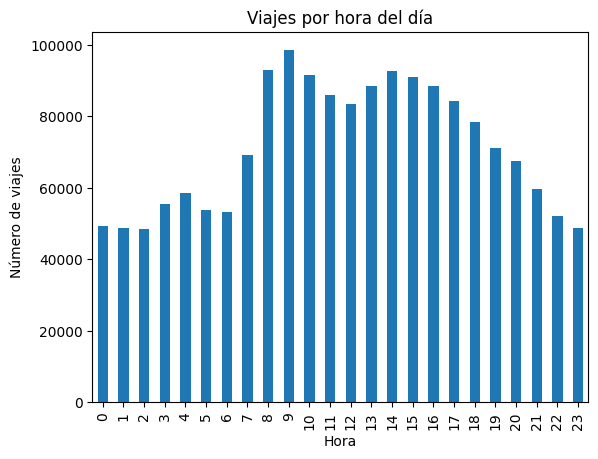

In [58]:
plt.figure()
df_trips["hour"] = df_trips["datetime"].dt.hour
df_trips.groupby("hour")["TRIP_ID"].count().plot(kind="bar")
plt.title("Viajes por hora del día")
plt.xlabel("Hora")
plt.ylabel("Número de viajes")
plt.show()

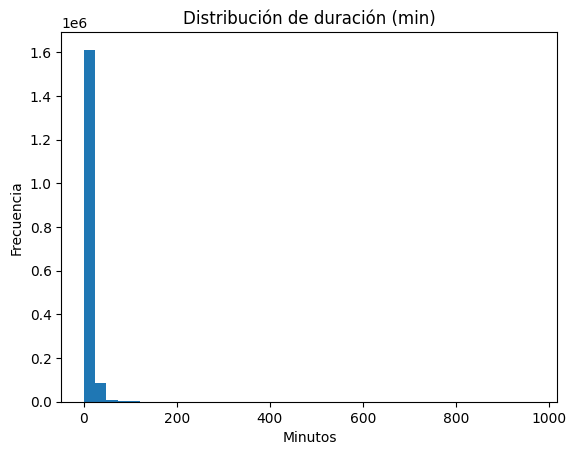

In [59]:
plt.figure()
plt.hist(df_trips["duration_min"], bins=40)
plt.title("Distribución de duración (min)")
plt.xlabel("Minutos")
plt.ylabel("Frecuencia")
plt.show()

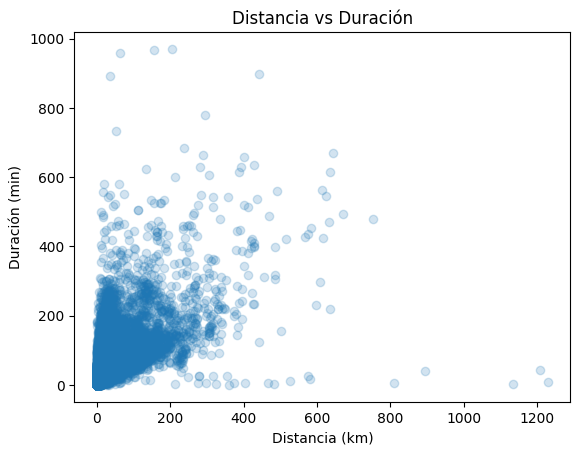

In [60]:
plt.figure()
plt.scatter(df_trips["distance_km"], df_trips["duration_min"], alpha=0.2)
plt.title("Distancia vs Duración")
plt.xlabel("Distancia (km)")
plt.ylabel("Duración (min)")
plt.show()

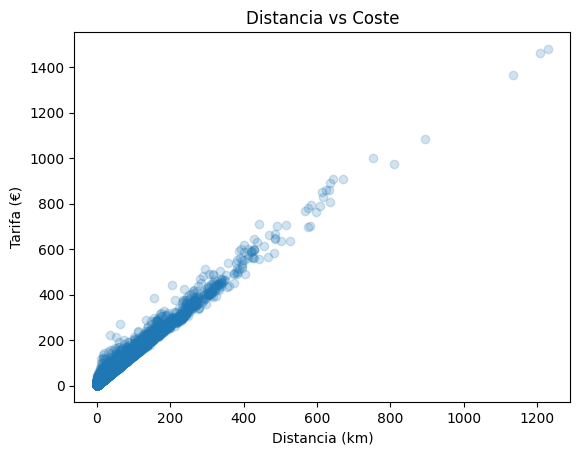

In [61]:
plt.figure()
plt.scatter(df_trips["distance_km"], df_trips["fare"], alpha=0.2)
plt.title("Distancia vs Coste")
plt.xlabel("Distancia (km)")
plt.ylabel("Tarifa (€)")
plt.show()

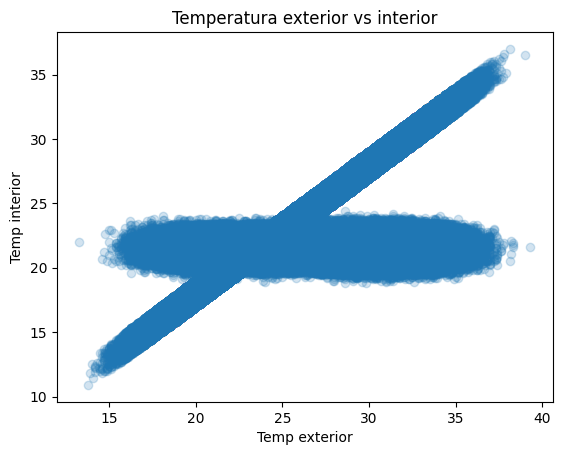

In [62]:
plt.figure()
plt.scatter(df_trips["temp_outside"], df_trips["temp_inside"], alpha=0.2)
plt.title("Temperatura exterior vs interior")
plt.xlabel("Temp exterior")
plt.ylabel("Temp interior")
plt.show()

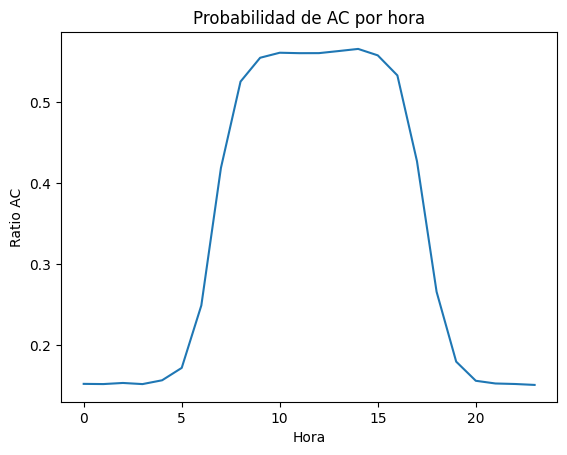

In [63]:
plt.figure()
ac_rate = df_trips.groupby("hour")["ac_requested"].mean()
ac_rate.plot()
plt.title("Probabilidad de AC por hora")
plt.xlabel("Hora")
plt.ylabel("Ratio AC")
plt.show()

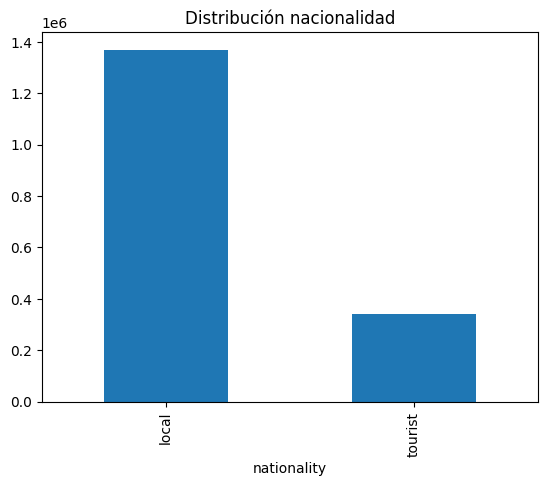

In [65]:
plt.figure()
df_trips["nationality"].value_counts().plot(kind="bar")
plt.title("Distribución nacionalidad")
plt.show()

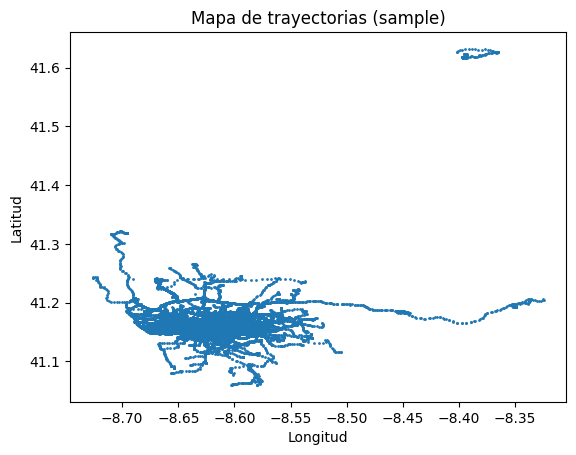

In [66]:
sample = df_trips.sample(1000)

lats = []
lons = []

for poly in sample["POLYLINE"]:
    coords = json.loads(poly)
    for lon, lat in coords:
        lats.append(lat)
        lons.append(lon)

plt.figure()
plt.scatter(lons, lats, s=1)
plt.title("Mapa de trayectorias (sample)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

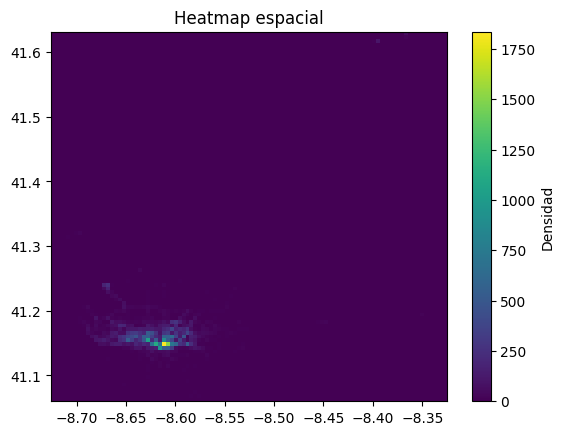

In [67]:
plt.figure()
plt.hist2d(lons, lats, bins=100)
plt.title("Heatmap espacial")
plt.colorbar(label="Densidad")
plt.show()

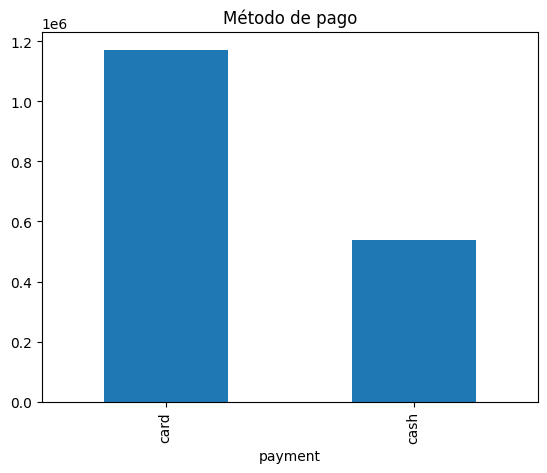

In [68]:
plt.figure()
df_trips["payment"].value_counts().plot(kind="bar")
plt.title("Método de pago")
plt.show()

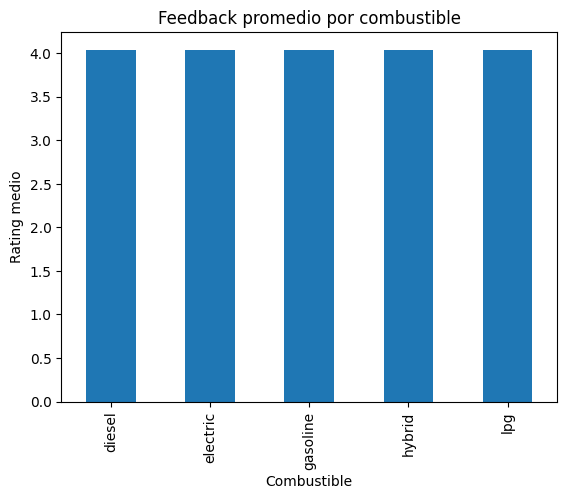

In [69]:
plt.figure()
df_trips.groupby("fuel_type")["avg_feedback"].mean().plot(kind="bar")
plt.title("Feedback promedio por combustible")
plt.xlabel("Combustible")
plt.ylabel("Rating medio")
plt.show()

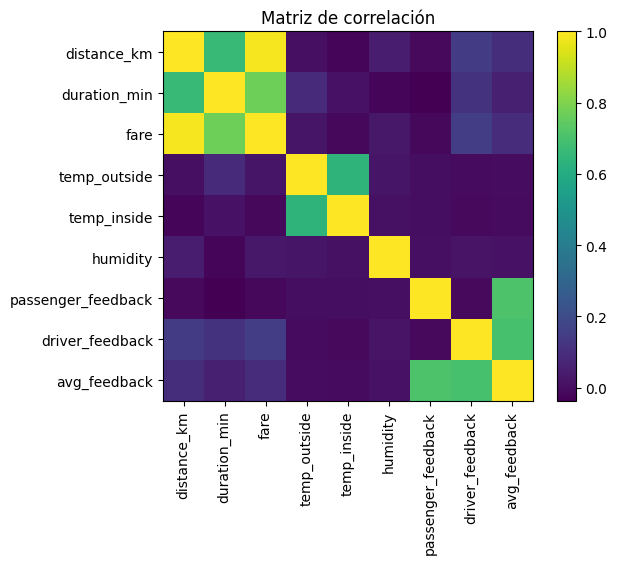

In [72]:
plt.figure()
corr = df_trips[
    ["distance_km","duration_min","fare",
     "temp_outside","temp_inside",
     "humidity","passenger_feedback",
     "driver_feedback","avg_feedback"]
].corr()

plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Matriz de correlación")
plt.show()

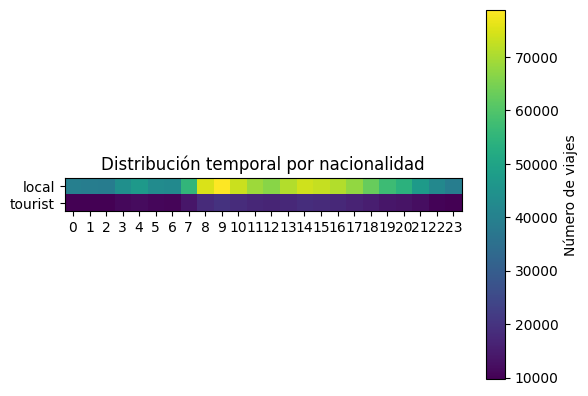

In [74]:
pivot = (
    df_trips
    .groupby(["hour","nationality"])["TRIP_ID"]
    .count()
    .unstack()
)

plt.figure()
plt.imshow(pivot.T)
plt.yticks([0,1], pivot.columns)
plt.xticks(range(24), range(24))
plt.colorbar(label="Número de viajes")
plt.title("Distribución temporal por nacionalidad")
plt.show()

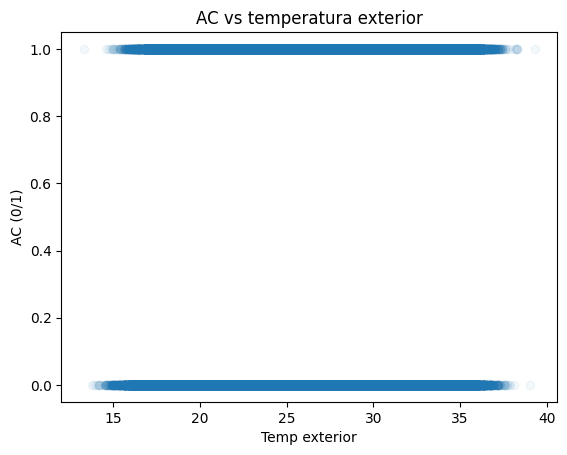

In [75]:
plt.figure()
plt.scatter(df_trips["temp_outside"],
            df_trips["ac_requested"].astype(int),
            alpha=0.05)
plt.title("AC vs temperatura exterior")
plt.xlabel("Temp exterior")
plt.ylabel("AC (0/1)")
plt.show()

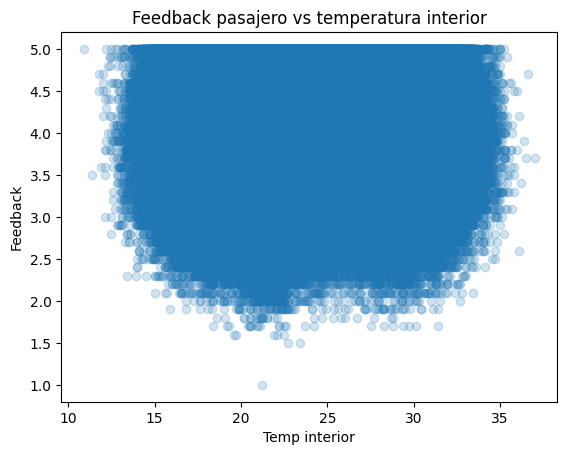

In [76]:
plt.figure()
plt.scatter(df_trips["temp_inside"],
            df_trips["passenger_feedback"],
            alpha=0.2)
plt.title("Feedback pasajero vs temperatura interior")
plt.xlabel("Temp interior")
plt.ylabel("Feedback")
plt.show()

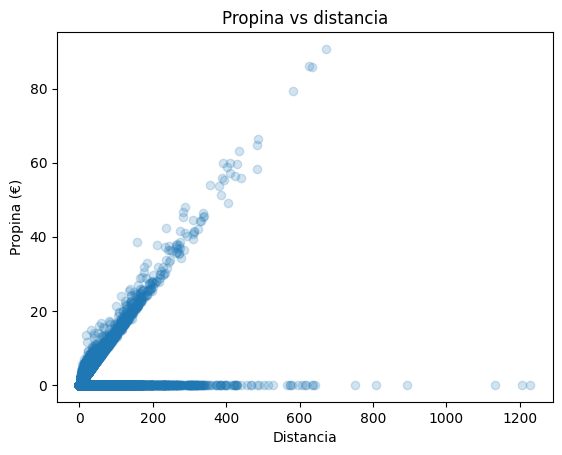

In [78]:
plt.figure()
plt.scatter(df_trips["distance_km"],
            df_trips["tip_amount"],
            alpha=0.2)
plt.title("Propina vs distancia")
plt.xlabel("Distancia")
plt.ylabel("Propina (€)")
plt.show()

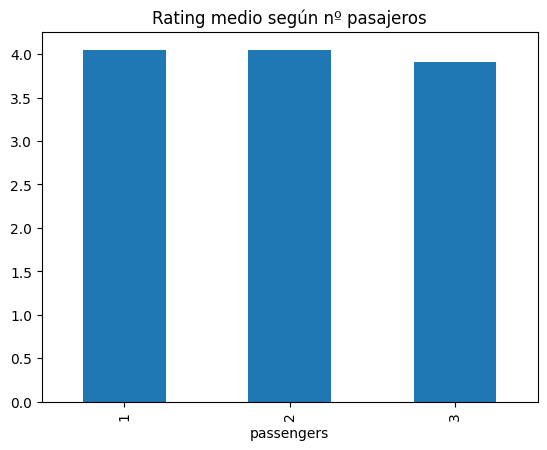

In [79]:
plt.figure()
df_trips.groupby("passengers")["avg_feedback"].mean().plot(kind="bar")
plt.title("Rating medio según nº pasajeros")
plt.show()

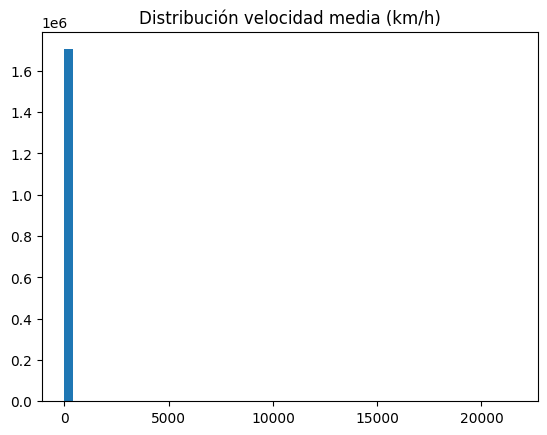

In [80]:
df_trips["speed_kmh"] = df_trips["distance_km"] / (df_trips["duration_min"]/60)

plt.figure()
plt.hist(df_trips["speed_kmh"], bins=50)
plt.title("Distribución velocidad media (km/h)")
plt.show()

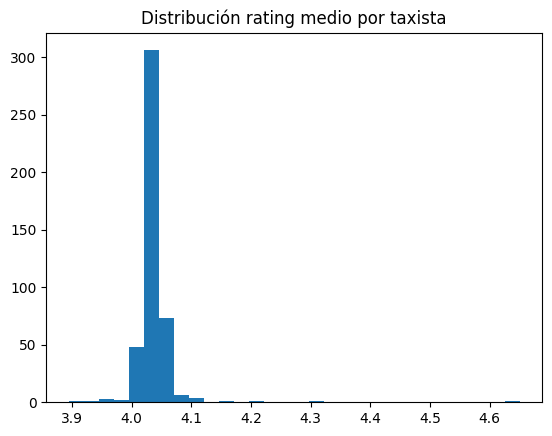

In [81]:
plt.figure()
plt.hist(df_drivers["driver_rating"], bins=30)
plt.title("Distribución rating medio por taxista")
plt.show()

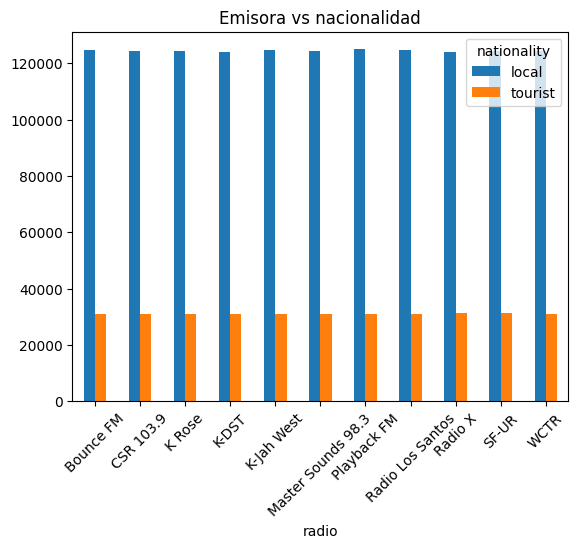

In [82]:
pivot_radio = (
    df_trips
    .groupby(["radio","nationality"])["TRIP_ID"]
    .count()
    .unstack()
)

pivot_radio.plot(kind="bar")
plt.title("Emisora vs nacionalidad")
plt.xticks(rotation=45)
plt.show()

## Exportamos a Parquet

In [86]:
df_trips.to_parquet(
    "../data/trips_memory.parquet",
    index=False,
    compression="snappy"
)

In [87]:
df_drivers.to_parquet(
    "../data/drivers_memory.parquet",
    index=False,
    compression="snappy"
)

In [89]:
!ls -la ../data/

total 3356524
drwxrwxr-x 2 manuel manuel       4096 Feb 26 23:02 .
drwxrwxr-x 7 manuel manuel       4096 Feb 26 21:59 ..
-rw-rw-r-- 1 manuel manuel          0 Feb 26 22:05 .gitkeep
-rw-rw-r-- 1 manuel manuel  540159049 Feb 26 00:35 archive.zip
-rw-rw-r-- 1 manuel manuel      14937 Feb 26 23:02 drivers_memory.parquet
-rw-rw-r-- 1 manuel manuel 1942848724 Sep 29  2019 train.csv
-rw-rw-r-- 1 manuel manuel  954028710 Feb 26 23:02 trips_memory.parquet
